In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay, auc
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from neural_network import *
import importlib
import plotting
importlib.reload(plotting)
from plotting import *

%matplotlib inline

In [2]:
# load in dataset
cancer = load_breast_cancer()

In [3]:
# prep data
X = cancer.data
target = cancer.target
target = target.reshape(target.shape[0], 1)

X_train, X_val, t_train, t_val = train_test_split(X, target, test_size=0.2, random_state=42)

scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [4]:
def nodes_layer_search(input_nodes, num_nodes, output_nodes, num_layers, scheduler, hidden_func=RELU, seed = 2024 ):
    "Returns accuracy for a nodes vs. layer grid search"
    scores = np.zeros((len(num_nodes), len(num_layers)))
    for i, nodes in enumerate(num_nodes):
        for j, layers in enumerate(num_layers):
            print(f'Nodes: {nodes}, Layers: {layers}')
            dims = (input_nodes, *[nodes]*layers, output_nodes)
            linear_regression = FFNN(dims,
                        hidden_func=hidden_func,
                        output_func=sigmoid,
                        cost_func=CostLogReg,
                        seed=seed)
            linear_regression.reset_weights()
            try:
                result = linear_regression.fit(X_train, t_train, scheduler, batches = 10, epochs=1000, X_val=X_val, t_val=t_val)
                scores[i, j] = result['val_accs'][-1]  # Adjust this line based on the actual key in the returned dictionary
            except:
                scores[i, j] = None
            print(f'{nodes=}, {layers=}')
    return scores

In [5]:
num_nodes = [4, 8, 16, 32, 64]
num_layers = [1, 2, 3, 4, 5]
input_nodes = X_train.shape[1]
output_nodes = 1

In [6]:
scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999)
RELU_scores = nodes_layer_search(input_nodes, num_nodes, output_nodes, num_layers, scheduler)
clear_output()
print(f'Finished gridsearh for {type(scheduler).__name__}!')

Finished gridsearh for Adam!


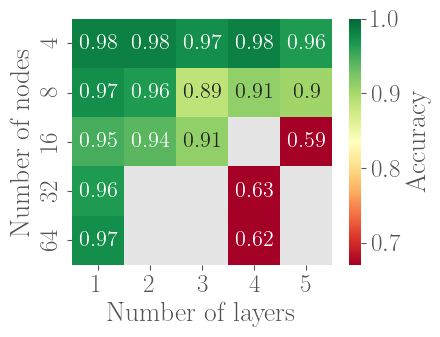

In [7]:
plot_heatmap(RELU_scores, num_layers, num_nodes, figname='FFNN_cals_RELU_nodes_layers_gridsearch')

In [8]:
scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999)
sigmoid_scores = nodes_layer_search(input_nodes, num_nodes, output_nodes, num_layers, scheduler, hidden_func=sigmoid)
clear_output()
print(f'Finished gridsearh for {type(scheduler).__name__}!')

Finished gridsearh for Adam!


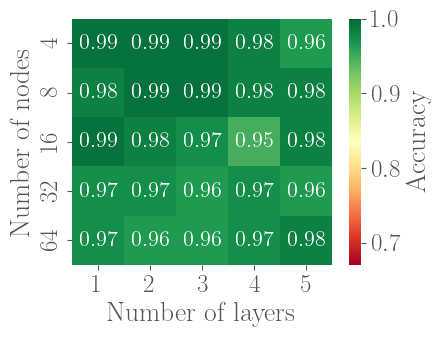

In [9]:
plot_heatmap(sigmoid_scores, num_layers, num_nodes, figname='FFNN_cals_sigmoid_nodes_layers_gridsearch')

Here 8 nodes and 2 layers seems to be a good architecture

In [10]:
scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999)
LRELU_scores = nodes_layer_search(input_nodes, num_nodes, output_nodes, num_layers, scheduler, hidden_func=LRELU)
clear_output()
print(f'Finished gridsearch for {type(scheduler).__name__}!')

Finished gridsearch for Adam!


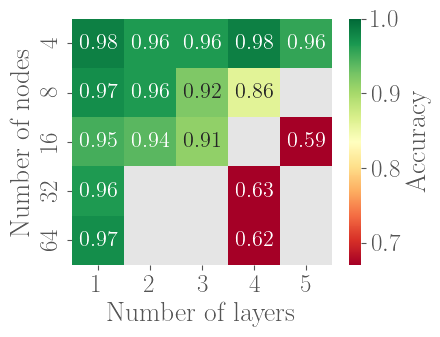

In [11]:
plot_heatmap(LRELU_scores, num_layers, num_nodes, figname='FFNN_cals_LRELU_nodes_layers_gridsearch')

Here we see that using the Sigmoid function for a network architecture of 32 nodes and 2 layers works well. With good accuracy in the surrounding architectures as well.

In [12]:
best_nodes = 8
best_layers = 2
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
regularizations = [0, 1e-4 ,1e-3, 1e-2]

In [13]:
scores_momentum = np.zeros((len(learning_rates), len(regularizations)))
scores_adagrad = np.zeros((len(learning_rates), len(regularizations)))
scores_rms_prop = np.zeros((len(learning_rates), len(regularizations)))
scores_adam = np.zeros((len(learning_rates), len(regularizations)))

schedulers = [Momentum, Adagrad, RMS_prop, Adam]

In [14]:
dims = (input_nodes, *[best_nodes]*best_layers, output_nodes)
linear_regression = FFNN(dims,
                        hidden_func=sigmoid,
                        output_func=sigmoid,
                        cost_func=CostLogReg,
                        seed=2024)
for scheduler in schedulers:
    for i, lr in enumerate(learning_rates):
        for j, reg in enumerate(regularizations):
            linear_regression.reset_weights()
            # put the result in a try except block to avoid errors
            try: 
                result = linear_regression.fit(X_train, t_train, scheduler(eta=lr), X_val=X_val, t_val=t_val, epochs=1000, batches=10, lam=reg)
            except:
                result = {'val_acc': ['NaN']}
            if scheduler == Momentum:
                try:
                    scores_momentum[i, j] = result['val_accs'][-1]
                except:
                    scores_momentum[i, j] = None
            elif scheduler == Adagrad:
                try:
                    scores_adagrad[i, j] = result['val_accs'][-1]
                except:
                    scores_adagrad[i, j] = None
            elif scheduler == RMS_prop:
                try:
                    scores_rms_prop[i, j] = result['val_accs'][-1]
                except:
                    scores_rms_prop[i, j] = None
            elif scheduler == Adam:
                try:
                    scores_adam[i, j] = result['val_accs'][-1]
                except:
                    scores_adam[i, j] = None
            print(f'{lr=}, {reg=}')
clear_output()
print(f'Finished gridsearhes for {(', ').join([i.__name__ for i in schedulers])}!')

Finished gridsearhes for Momentum, Adagrad, RMS_prop, Adam!


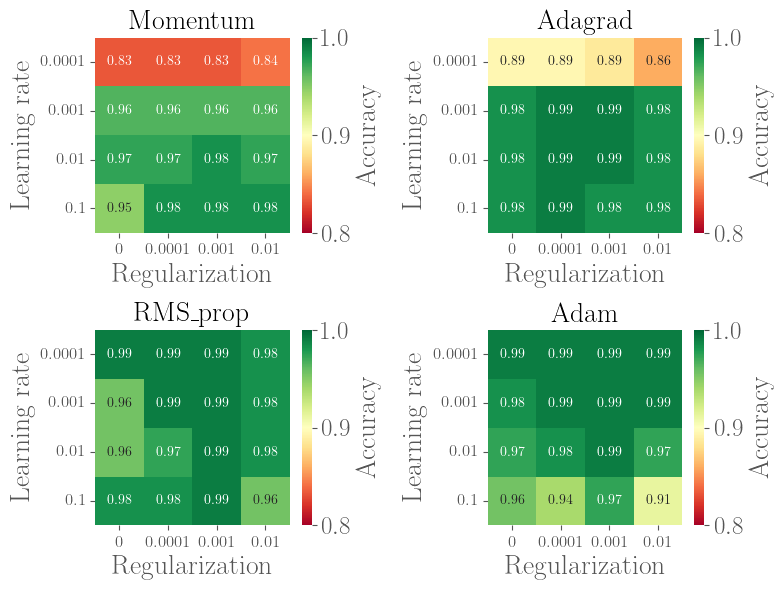

In [33]:
#plot the results
plt.figure(figsize=(8, 6))
plt.style.use('ggplot')

    # Set standardized params for each type of plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.subplot(2, 2, 1)
p = sns.heatmap(scores_momentum, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn', cbar=True, cbar_kws={'label': 'Accuracy'}, vmin=0.8, vmax=1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('Momentum', fontsize = 20)
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.subplot(2, 2, 2)
p = sns.heatmap(scores_adagrad, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn', cbar=True, cbar_kws={'label': 'Accuracy'}, vmin=0.8, vmax=1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('Adagrad', fontsize = 20)
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.subplot(2, 2, 3)
p = sns.heatmap(scores_rms_prop, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn', cbar=True, cbar_kws={'label': 'Accuracy'}, vmin=0.8, vmax=1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('RMS_prop', fontsize = 20)
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.subplot(2, 2, 4)
p = sns.heatmap(scores_adam, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn', cbar=True, cbar_kws={'label': 'Accuracy'}, vmin=0.8, vmax=1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.title('Adam', fontsize = 20)
plt.setp(p.get_xticklabels(), fontsize = 'large', horizontalalignment='center', rotation=0)
plt.setp(p.get_yticklabels(), fontsize = 'large', horizontalalignment='right')

plt.tight_layout()
plt.savefig('../figures/FFNN_cals_sigmoid_8n_2l_compare_schedulers.pdf')
plt.show()

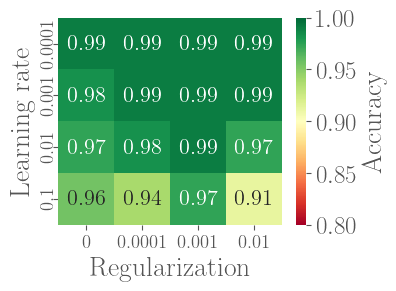

In [16]:
fig, ax = make_plot('gridsearch')
plt.setp(ax.get_xticklabels(), fontsize = 'small', horizontalalignment='center')
plt.setp(ax.get_yticklabels(), fontsize = 'small', horizontalalignment='center')
sns.heatmap(scores_adam, annot=True, xticklabels=regularizations, yticklabels=learning_rates, cmap='RdYlGn', cbar=True, cbar_kws={'label': 'Accuracy'}, vmin=0.8, vmax=1)
plt.xlabel('Regularization')
plt.ylabel('Learning rate')
plt.tight_layout()
plt.savefig('../figures/FFNN_cals_sigmoid_8n_2l_ADAM_best.pdf', bbox_inches='tight')
plt.show()

Using Adam with lr=0.001 and reg=0.001

In [17]:
best_lr = 0.001
best_reg = 0.001
best_scheduler = Adam

dims = (input_nodes, *[best_nodes]*best_layers, output_nodes)
neural_network = FFNN(dims,
                        hidden_func=sigmoid,
                        output_func=sigmoid,
                        cost_func=CostLogReg,
                        seed=2024)

result = neural_network.fit(X_train, t_train, best_scheduler(eta=best_lr), X_val=X_val, t_val=t_val, epochs=1000, batches=10, lam=best_reg)
predictions = neural_network.predict(X_val)

clear_output()
print('Finished training of Neural network!')

Finished training of Neural network!


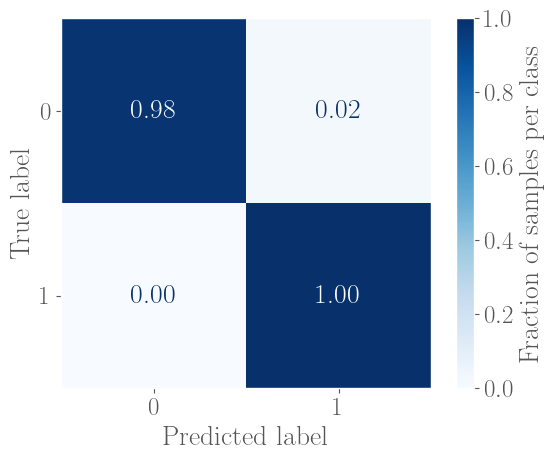

In [18]:
plt.style.use('ggplot')

# Set standardized params for each type of plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.labelspacing'] = 0.25 
cm = confusion_matrix(t_val, predictions, normalize='true')  # Normalizes by row

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
disp.plot(cmap='Blues', values_format='.2f')  # Display values as decimals with two decimal places
# Add a colorbar label
disp.im_.colorbar.set_label("Fraction of samples per class")
plt.grid(False)
plt.savefig('../figures/FFNN_clas_ADAM_lr0.001_reg0.001_confusion.pdf', bbox_inches='tight')